In [1]:
import sys
import numpy as np
sys.path.insert(0, '/home/david/Institut/data-analysis/rydanalysis/')
from rydanalysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
mpl.rc('image', cmap='viridis')
sns.set_style("darkgrid")
from lmfit import Model,Parameters
import xarray as xr
import plotly.express as px

In [2]:
import plotly.io as pio
pio.renderers.default = "browser"

In [3]:
from scipy import ndimage

In [4]:
binning_scale=1

In [5]:
seq = ExpSequence("/home/david/Institut/2019_IEI_new/July/25/DensityScanOvernight")
#shot = SingleShot("/home/david/Institut/2019_IEI/July/02/scanblueresonance_FINAL_averaged_images/2019-06-05_00.fts")

In [6]:
variables= seq.variables.copy()
for i,shot in enumerate(seq.iter_single_shots()):
    image=shot.image
    absorb = calc_absorbtion_image(image)
    absorb = crop_image(absorb,xslice=slice(10,90),yslice=slice(10,380))
    od = absorbtion_to_OD(absorb)
    od = nn_replace_nonfinite(od,~np.isfinite(od))
    shot.optical_density = od

/home/david/Institut/data-analysis/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning:

divide by zero encountered in true_divide

/home/david/Institut/data-analysis/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning:

invalid value encountered in true_divide

/home/david/Institut/data-analysis/rydanalysis/rydanalysis/single_shot/image_processing.py:9: RuntimeWarning:

divide by zero encountered in log

/home/david/Institut/data-analysis/rydanalysis/rydanalysis/single_shot/image_processing.py:9: RuntimeWarning:

invalid value encountered in log



In [7]:
#od = ndimage.gaussian_filter(od, 4, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fit2dGaussian(image):
    image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2dGaussian(image)
    fit.params = fit.guess(image)
    #fit.params = restrict_to_init(fit.params,dev=0.2)
    #fit.params['amp'].max = fit.params['amp'].value*(1+0.5)
    #fit.params['amp'].min = fit.params['amp'].value*(1-0.5)
    #fit.params['cen_x'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_x'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['cen_y'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_y'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['offset'].max = fit.params['amp'].value*(1+2)
    
    fit.params['offset'].vary = False
    fit.params['offset'].value = 0
    fit.params['amp'].min = 0
    fit.fit_data()
    return fittoSeries(fit)

In [8]:

def fit22dGaussian(image):
    model_twoG = Model(two_Gaussian)

    params = Parameters()

    params = model_twoG.make_params()



    # cloud distribution
    params.add('amp1',value=0.1)
    params.add('cen_y1',value=128*binning_scale,min=100*binning_scale,max=200*binning_scale)
    params.add('cen_x1',value=43*binning_scale,min=20*binning_scale,max=60*binning_scale)
    params.add('sig_x1',value=27*binning_scale,min=10*binning_scale,max=100*binning_scale)
    params.add('sig_y1',value=66*binning_scale,min=10*binning_scale,max=100*binning_scale)
    params.add('theta1',value=0,min=-np.pi/10,max=np.pi/10)

    # EIT/Autler-Townes-dip
    params.add('amp2',value=0.00,vary=True)
    params.add('cen_y2',value=150*binning_scale,min=140*binning_scale,max=160*binning_scale,vary=True)
    params.add('cen_x2',value=39*binning_scale,min=36*binning_scale,max=48*binning_scale,vary=True)
    params.add('sig_x2',value=6.3*binning_scale,min=5.8*binning_scale,max=6.9*binning_scale,vary=True)
    #params.add('sigma_y2',value=10,min=3,max=15)
    params.add('sig_y2',expr='sig_x2',vary=True)
    params.add('theta2',value=0.0000001,min=0,max=np.pi,vary=False)

    # offset
    params.add('offset',value=0.000001,vary=False)
    model = model_twoG
    
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    
    image_flat=image.flatten() 
    #weights_flat=image_weights.flatten()
    out = model.fit(image_flat,params,xy_mesh=(x,y))
    return out

In [9]:
def stderr_weighted_average(g):
    rel_err = g.amp.stderr/g.amp.value
    weights = 1/rel_err
    return (g.image_od * weights).sum()/weights.sum()

In [10]:
data = seq.variables.copy()

In [11]:
data['image_od'] = [shot.optical_density[0] for shot in seq.iter_single_shots()]

In [12]:
data=data.iloc[0:600]

data['image_light'] = [shot.image[3] for shot in seq.iter_single_shots()]
data['image_atoms'] = [shot.image[1] for shot in seq.iter_single_shots()]
data['image_bg'] = [shot.image[5] for shot in seq.iter_single_shots()]

data['light'] = data.image_light-data.image_bg
data['atoms'] = data.image_atoms-data.image_bg
data['diff'] = data.light- data.atoms

In [13]:
fit_res = data['image_od'].apply(fit2dGaussian)
fit_res.to_csv('fit_res.csv')
fit_res[data.columns] = data
data = fit_res

Apply conditional filters to data set

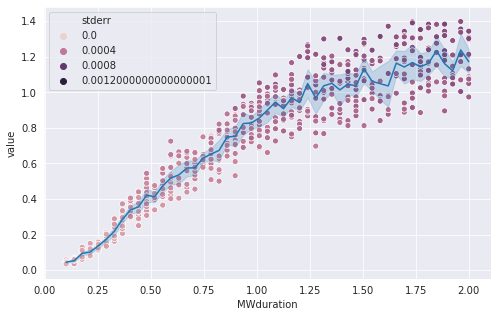

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=data.MWduration,y=data.amp.value,hue = data.amp.stderr,markers='O',hue_norm=(0,0.0010))
sns.lineplot(x=data.MWduration,y=data.amp.value)

In [15]:
#data.amp.value.groupby()plot()

IndexError: index 16 is out of bounds for axis 0 with size 16

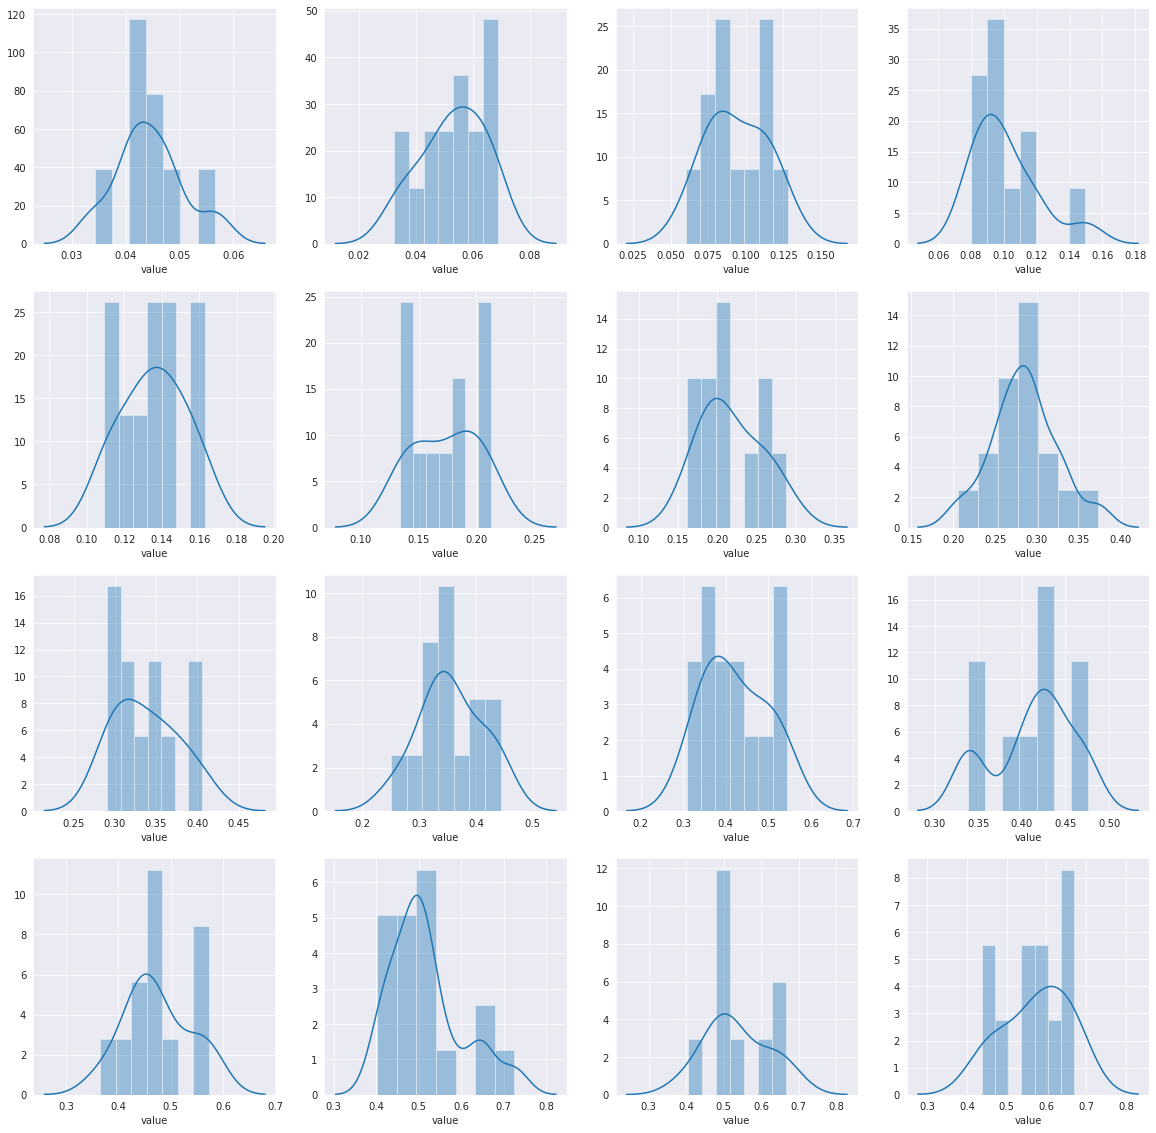

In [16]:
fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].amp.value,bins=7,ax=ax.flatten()[i])

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].cen_y.value,bins=7,ax=ax.flatten()[i])

### Group by *MWduration*

## Fit EIT dip

fit = data.image_od.apply(fit22dGaussian)

fit_res = fit.apply(fittoSeries)

In [17]:
mw_av = data.groupby('MWduration')['image_od'].apply(np.mean)

fit = mw_av.apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

Text(0, 0.5, '3lvl/2lvl OD')

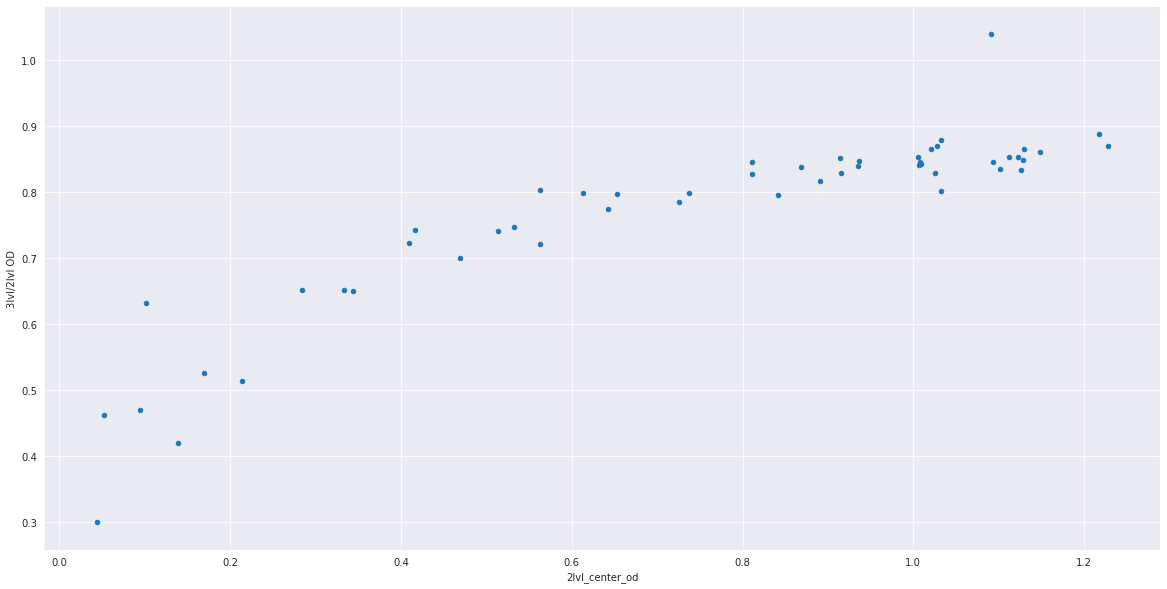

In [18]:
fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])

fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
fit_res['32ratio'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']

#fit_res['3lvl_center_od_std'] = fit.apply(lambda x: x.eval_uncertainty(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])
#fit_res['2lvl_center_od_std'] = np.sqrt(fit_res['3lvl_center_od_std']**2 + fit_res.amp2.value**2)

#fit_res['32ratio_std'] = fit_res['32ratio'] * np.sqrt((fit_res['3lvl_center_od_std']/fit_res['3lvl_center_od'])**2 + (fit_res['3lvl_center_od_std']/fit_res['2lvl_center_od'])**2)
fig,ax = plt.subplots(figsize=(20,10))
#sns.scatterplot(data = res,y='32ratio',x='binning0',ax=ax)
#sns.lineplot(data = res,y='32ratio',x='binning0',ax=ax,ci='sd')
#sns.lineplot(data=out)
#fig = px.scatter(fit_res,x='binning0',y='3vs2lvl_od')
#fig.show()
fit_res.plot.scatter(x='2lvl_center_od',y='32ratio',ax=ax,style='--o')
#sns.scatterplot(x='2lvl_center_od',y='32ratio',data=fit_res)
plt.ylabel("3lvl/2lvl OD")

In [19]:
px.scatter(fit_res,x='2lvl_center_od',y='32ratio',error_y='32ratio_std')

ValueError: Value of 'error_y' is not the name of a column in 'data_frame'. Expected one of [('amp1', 'value'), ('amp1', 'min'), ('amp1', 'max'), ('amp1', 'init_value'), ('amp1', 'stderr'), ('amp1', 'vary'), ('cen_x1', 'value'), ('cen_x1', 'min'), ('cen_x1', 'max'), ('cen_x1', 'init_value'), ('cen_x1', 'stderr'), ('cen_x1', 'vary'), ('cen_y1', 'value'), ('cen_y1', 'min'), ('cen_y1', 'max'), ('cen_y1', 'init_value'), ('cen_y1', 'stderr'), ('cen_y1', 'vary'), ('sig_x1', 'value'), ('sig_x1', 'min'), ('sig_x1', 'max'), ('sig_x1', 'init_value'), ('sig_x1', 'stderr'), ('sig_x1', 'vary'), ('sig_y1', 'value'), ('sig_y1', 'min'), ('sig_y1', 'max'), ('sig_y1', 'init_value'), ('sig_y1', 'stderr'), ('sig_y1', 'vary'), ('theta1', 'value'), ('theta1', 'min'), ('theta1', 'max'), ('theta1', 'init_value'), ('theta1', 'stderr'), ('theta1', 'vary'), ('amp2', 'value'), ('amp2', 'min'), ('amp2', 'max'), ('amp2', 'init_value'), ('amp2', 'stderr'), ('amp2', 'vary'), ('cen_x2', 'value'), ('cen_x2', 'min'), ('cen_x2', 'max'), ('cen_x2', 'init_value'), ('cen_x2', 'stderr'), ('cen_x2', 'vary'), ('cen_y2', 'value'), ('cen_y2', 'min'), ('cen_y2', 'max'), ('cen_y2', 'init_value'), ('cen_y2', 'stderr'), ('cen_y2', 'vary'), ('sig_x2', 'value'), ('sig_x2', 'min'), ('sig_x2', 'max'), ('sig_x2', 'init_value'), ('sig_x2', 'stderr'), ('sig_x2', 'vary'), ('sig_y2', 'value'), ('sig_y2', 'min'), ('sig_y2', 'max'), ('sig_y2', 'init_value'), ('sig_y2', 'stderr'), ('sig_y2', 'vary'), ('theta2', 'value'), ('theta2', 'min'), ('theta2', 'max'), ('theta2', 'init_value'), ('theta2', 'stderr'), ('theta2', 'vary'), ('offset', 'value'), ('offset', 'min'), ('offset', 'max'), ('offset', 'init_value'), ('offset', 'stderr'), ('offset', 'vary'), ('3lvl_center_od', ''), ('2lvl_center_od', ''), ('32ratio', '')] but received: 32ratio_std

In [ ]:
for f,im in zip(fit,mw_av):
    shape = im.shape
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].imshow(im,cmap='viridis',vmin=0,vmax=1.4)
    ax[0].contour(f.best_fit.reshape(shape))
    ax[1].imshow(f.residual.reshape(shape), cmap='coolwarm')

### Group density bins

In [20]:
results = pd.DataFrame()
data['fitted_amp_binning'] =  pd.cut(data.amp.value,bins = np.linspace(0.02,1.4,40))
grouping = data.groupby('fitted_amp_binning')
results['averaged_od'] = grouping.apply(stderr_weighted_average)

fit = results['averaged_od'].apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

/home/david/Downloads/.anaconda3/envs/mypy3/lib/python3.7/site-packages/pandas/plotting/_core.py:716: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Text(0, 0.5, '3lvl/2lvl OD')

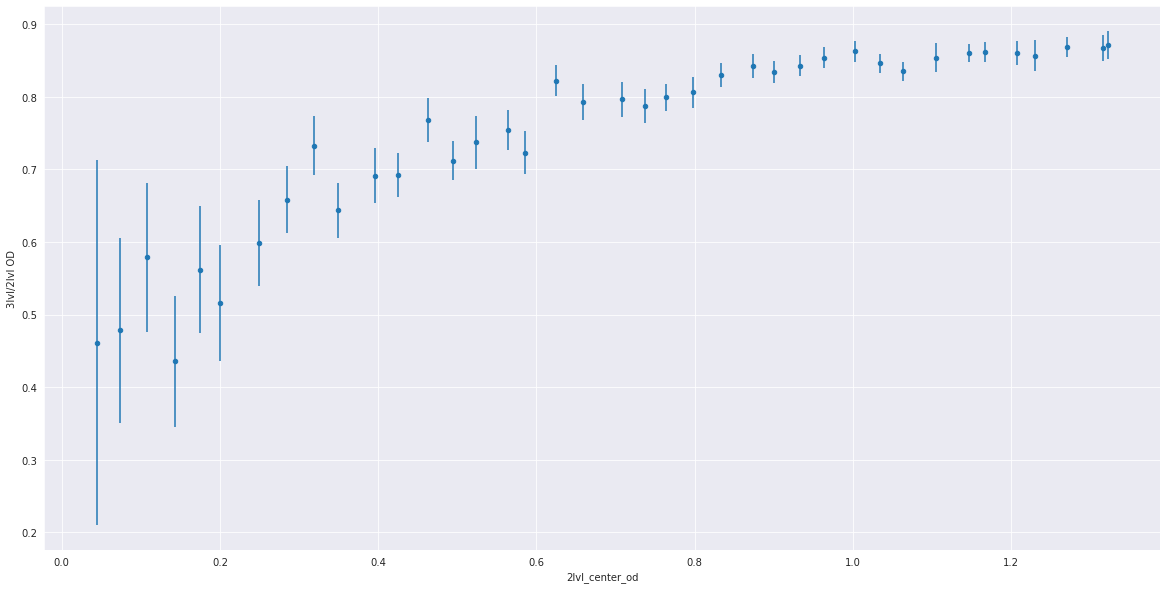

In [21]:
fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])

fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
fit_res['32ratio'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']

fit_res['3lvl_center_od_std'] = fit.apply(lambda x: x.eval_uncertainty(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])
fit_res['2lvl_center_od_std'] = np.sqrt(fit_res['3lvl_center_od_std']**2 + fit_res.amp2.value**2)

fit_res['32ratio_std'] = fit_res['32ratio'] * np.sqrt((fit_res['3lvl_center_od_std']/fit_res['3lvl_center_od'])**2 + (fit_res['3lvl_center_od_std']/fit_res['2lvl_center_od'])**2)
fig,ax = plt.subplots(figsize=(20,10))
#sns.scatterplot(data = res,y='32ratio',x='binning0',ax=ax)
#sns.lineplot(data = res,y='32ratio',x='binning0',ax=ax,ci='sd')
#sns.lineplot(data=out)
#fig = px.scatter(fit_res,x='binning0',y='3vs2lvl_od')
#fig.show()
fit_res.plot.scatter(x='2lvl_center_od',y='32ratio',yerr='32ratio_std',ax=ax,style='--o')
#sns.scatterplot(x='2lvl_center_od',y='32ratio',data=fit_res)
plt.ylabel("3lvl/2lvl OD")

In [ ]:
fit_res.sig_x2

In [ ]:
fit_res.amp2.stderr

In [ ]:
for f,im in zip(fit,mw_av):
    shape = im.shape
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].imshow(im,cmap='viridis',vmin=0,vmax=1.4)
    ax[0].contour(f.best_fit.reshape(shape))
    ax[1].imshow(f.residual.reshape(shape), cmap='coolwarm')

In [ ]:
fit_res["3lvl_center_od"].plot()
fit_res["2lvl_center_od"].plot()

In [ ]:
fit_res.sig_x2.value.plot()


In [ ]:
for f,im in zip(fit,results.averaged_od):
    shape = im.shape
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].imshow(im,cmap='viridis',vmin=0,vmax=0.4)
    ax[0].contour(f.best_fit.reshape(shape))
    ax[1].imshow(f.residual.reshape(shape), cmap='coolwarm',vmin=-0.1,vmax=0.1)

In [ ]:
def three_vs_two_lvl(n,r0,n0):
    fbl = n0*n**(4./5)
    return (r0 + fbl)/(1+fbl)
model = Model(three_vs_two_lvl)
params = model.make_params()
params['r0'].value = 0.66
params['n0'].value = 1

In [ ]:
out = model.fit(fit_res['3vs2lvl_od'].values,n=fit_res['2lvl_center_od'],params=params,nan_policy='omit')

In [ ]:
plt.figure(figsize=(10,10))
fit_res.plot(y="3vs2lvl_od",x="2lvl_center_od",style='o-')
x=np.arange(0.2,0.8,0.01)